# Interpolación spline cúbica de clase $\mathcal{C}^2$ con Python

Autor: Pedro González Rodelas

Fecha de la primera versión: 22/03/2022

Sucesivas revisiones: 22 y 23/03/2023

Fecha de la última revisión: 29/03/2023

Estructura del notebook y algunos ejemplos tomados o adaptados de los libros:

- "Numerical Python: A Practical Techniques Approach for Industry" de Robert Johansson. Edit. Apress (2015) con ISBN-13 (electronic): 978-1-4842-0553-2
- "Numerical Methods in Engineering with Python 3" de Jaan Kiusalaas. Edit Cambridge Univ. Press (2013) con ISBN: 978-1-107-03385-6
- "Análisis Numérico con Mathematica" de V. Ramírez, D. Barrera, M. Pasadas y P. González. Edit. Ariel Ciencia (2001) con ISBN: 84-344-8036-0. Dep. Legal: B.31.425-2001 (consultar también el siguiente [link](https://www.ugr.es/~prodelas/AnNumCaminos/ftp/Tema6.htm))

En esta práctica nos ocuparemos de varias de las posibilidades que tenemos para definir y trabajar con splines cúbicas de clase $\mathcal{C}^2$ en **Python**. 

## Carga de los módulos

Antes de empezar a realizar cualquier cálculo numérico o simbólico debemos de cargar los correspondientes módulos de Python que implementan la mayoría de funciones y procedimientos necesarios para ello: `NumPy` y `SymPy`, que serán cargados con los pseudónimos `np` y `sp`, respectivamente. Además cargaremos la función del módulo `random` que nos permitirá generar números aleatorios, cada vez que los necesitemos.

In [1]:
import numpy as np   # Importamos el módulo NumPy con el pseudónimo np
import sympy as sp   # Importamos el módulo SymPy con el pseudónimo sp
from sympy import *  # Con esta última opción no tendremos que poner sp.
# sp.init_printing()

In [2]:
# usaremos una opción para poder visualizar los gráficos incrustados 
# en línea dentro de este mismo notebook
%matplotlib inline 
import matplotlib.pyplot as plt  # 

In [3]:
import numpy.polynomial as P # cargaremos el submódulo polynomial, 
# situado dentro del módulo NumPy, con el pseudónimo P

In [4]:
from scipy import interpolate # importamos el submódulo interpolate
?interpolate

In [5]:
from random import random 
# Importamos la función generadora de números pseudoaleatorios

## Definición de ciertas funciones empleadas

También definiremos cierta función propia, `mychop`, que nos permitirá cambiar por $0$ cualquier valor que obtengamos, después de ciertos cálculos que involucren errores de redondeo, propios del cálculo con números en coma flotante. A su vez usaremos una versión vectorizada de la misma, que podremos aplicar a cualquier lista, tupla o array con valores numéricos en coma flotante.

In [6]:
def mychop(expr, max=10**(-15)): 
    if abs(expr) > max:
      return expr 
    else:
      return 0

chop_vec = np.vectorize(mychop)

También recordamos aquí las diferentes expresiones que pueden tener los correspondientes polinomios de interpolación que cumplen ciertos datos concretos, ya sean de tipo Lagrange (de la función sin derivar) como de tipo Hermite (a partir de derivadas de la función) en algún punto concreto.

In [7]:
def parabolaconderivada(x,d,xL,yL,xR,yR):
    """parábola con derivada fijada en el primer punto"""
    return (yL*(xL-xR)**2+(x-xL)*(x-xR)*(d*(xL-xR)+(yR-yL))
            +(x-xL)*(xL-xR)*(yL-yR))/(xL-xR)**2

def cubica(x,x1,y1,x2,y2,x3,y3,x4,y4):
    """cúbica que pasa por cuatro puntos dados"""
    return y1+(x-x1)*(x-x2)*(x-x3)*(x1**2*x2*y3-x1**2*x2*y4
        -x1**2*x3*y2+x1**2*x3*y4+x1**2*x4*y2-x1**2*x4*y3
        -x1*x2**2*y3+x1*x2**2*y4+x1*x3**2*y2-x1*x3**2*y4
        -x1*x4**2*y2+x1*x4**2*y3+x2**2*x3*y1-x2**2*x3*y4
        -x2**2*x4*y1+x2**2*x4*y3-x2*x3**2*y1+x2*x3**2*y4
        +x2*x4**2*y1-x2*x4**2*y3+x3**2*x4*y1-x3**2*x4*y2
        -x3*x4**2*y1+x3*x4**2*y2)/(x1**3*x2**2*x3-x1**3*x2**2*x4
        -x1**3*x2*x3**2+x1**3*x2*x4**2+x1**3*x3**2*x4-x1**3*x3*x4**2
        -x1**2*x2**3*x3+x1**2*x2**2*x4+x1**2*x2*x3**3-x1**2*x2*x4**3
        -x1**2*x3**3*x4+x1**2*x3*x4**3+x1*x2**3*x3**2-x1*x2**3*x4**2
        -x1*x2**2*x3**3+x1*x2**2*x4**3+x1*x3**3*x4**2-x1*x3**2*x4**3
        -x2**3*x3**2*x4+x2**3*x3*x4**2+x2**2*x3**3*x4-x2**2*x3*x4**3
        -x2*x3**3*x4**2+x2*x3**2*x4**3)-(x-x1)*(x-x2)*(x1*y2-x1*y3
        -x2*y1+x2*y3+x3*y1-x3*y2)/(x1**2*x2-x1**2*x3-x1*x2**2
        +x1*x3**2+x2**2*x3-x2*x3**2)+(x-x1)*(y1-y2)/(x1-x2)

def cubicaconderivadas(x,xL,yL,dL,xR,yR,dR):
    """cúbica con datos de Lagrange y Hermite en ambos extremos"""
    D = (dL*xL-dL*xR+dR*xL-dR*xR-2*(yL-yR))/(xL-xR)**3
    return parabolaconderivada(x,dL,xL,yL,xR,yR) + D*(x-xL)**2*(x-xR)

## Spline cúbico de interpolación Lagrangiana  de clase $C^2$

En esta sección se muestra cómo obtener un spline cúbico de interpolación de clase $\mathcal{C}^2$, una vez especificados los nodos de interpolación: $x_0, x_1, \ldots, x_n$, y los valores que deben ser interpolados:  $y_0, y_1, \ldots, y_n$. El correspondiente espacio de los splines cúbicos de clase $\mathcal{C}^2$ se suele denotar por $S_3(x_0, x_1,\ldots,x_n)$. 

Pero ya que la dimensión de este espacio es $n+3$, y solo estamos imponiendo $n+1$ condiciones de Lagrange, sabemos que aún tendríamos dos grados de libertad disponibles, con lo cuál podremos elegir libremente otras dos condiciones adicionales para poder tener planteado un problema unisolvente.

Entre las múltiples posibilidades que se podrían considerar, las más habituales son las siguiente:

* spline cúbico natural, en el que se pide que $s''(x_0) = 0 = s''(x_n)$.
* spline cúbico periódico, en el que se pide que $s'(x_0) = s''(x_n)$ y  $s''(x_0)= s''(x_n)$.
* spline cúbico sujeto, en el que se fijan los valores de la derivada primera en los extremos: $s'(x_0)=d_0$ y $s'(x_n)=d_n$.

Especificamos unos nodos o partición concreta del intervalo en cuestión.

In [8]:
from sympy import pi  # no haría falta si ya hemos importado el módulo con *

In [9]:
a = 0; b = 2*pi

In [10]:
(a,b)

(0, 2*pi)

In [11]:
n = 5        # n = 5 originariamente
# Si se prefiere trabajar con decimales en coma flotante
# x = np.linspace(float(a),float(b),n+1)
# Nótese que a partir de este momento x será un array que contiene la
# partición uniforme construida a partir de n partes iguales del intervalo
# Si preferimos trabajar simbólicamente y construir nosotros la partición
x = [a+k*(b-a)/n for k in range(n+1)]
x 

[0, 2*pi/5, 4*pi/5, 6*pi/5, 8*pi/5, 2*pi]

In [12]:
z = sp.Symbol('z')  # se empleará la letra z para tratarla como símbolo
def f(z):
    return sin(z)
f_vec = np.vectorize(f)
# Esta última versión vectorizada de la función simbólica nos permitirá
# poder evaluarla numéricamente de manera vectorizada, en arrays de Numpy

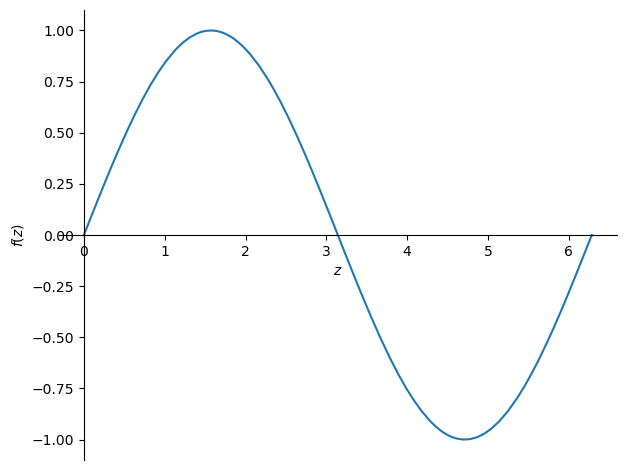

In [13]:
sp.plot(f(z),(z,a,b));  # nótese que aquí estaríamos usando la versión sp

In [14]:
y = f_vec(x)   # aquí usamos la versión vectorizada de la función
y

array([0, sqrt(sqrt(5)/8 + 5/8), sqrt(5/8 - sqrt(5)/8),
       -sqrt(5/8 - sqrt(5)/8), -sqrt(sqrt(5)/8 + 5/8), 0], dtype=object)

In [15]:
sp.diff(f(z),z),sp.diff(f(z),z,2)  # sin embargo aquí es de tipo simbólico

(cos(z), -sin(z))

In [16]:
def df(z):                  # pudiendo definir su derivada
    return cos(z)        # también simbolicamente
df_vec = np.vectorize(df)   # y vectorizarla igualmente

In [17]:
def d2f(z):                   # en este caso tendríamos la derivada segunda
    return -sin(z)
d2f_vec = np.vectorize(d2f)   # también vectorizada

In [18]:
df_vec(x)     # que podremos evaluarla a la vez en todos los nodos x

array([1, -1/4 + sqrt(5)/4, -sqrt(5)/4 - 1/4, -sqrt(5)/4 - 1/4,
       -1/4 + sqrt(5)/4, 1], dtype=object)

In [19]:
d2f_vec(x)     # que podremos evaluarla a la vez en todos los nodos x

array([0, -sqrt(sqrt(5)/8 + 5/8), -sqrt(5/8 - sqrt(5)/8),
       sqrt(5/8 - sqrt(5)/8), sqrt(sqrt(5)/8 + 5/8), 0], dtype=object)

#### Base de potencias truncadas cúbicas

Una posibilidad para obtener estos splines cuadráticos de clase $\mathcal{C}^2$ sería trabajar con la correspondiente base de potencias truncadas, que recordamos a continuación.

In [20]:
z,m = sp.symbols('z,m')
def potrunc(z,m):
    """potencia truncada z_m^m"""
    return (z**m)*(z>0)

In [21]:
a,b

(0, 2*pi)

In [22]:
x[0], x[-1]

(0, 2*pi)

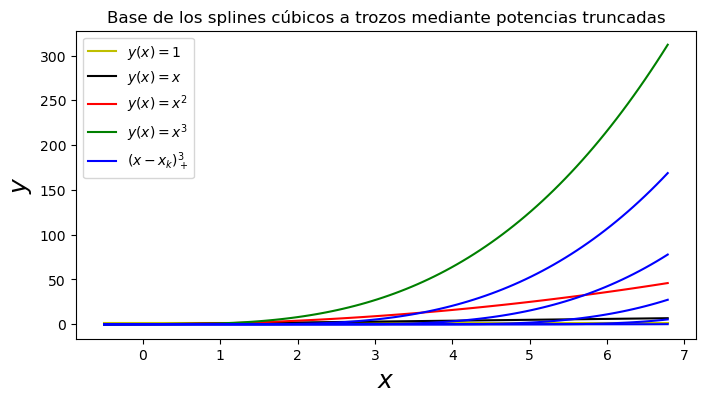

In [23]:
nxx = 100
xx = np.linspace(float(x[0]-0.5),float(x[-1]+0.5),nxx)

fig,ax = plt.subplots(figsize=(8,4))
yy = np.ones(nxx); plt.plot(xx,yy,'y',label='$y(x)=1$')
yy = xx; plt.plot(xx,yy,'k',label='$y(x)=x$')
yy = xx**2; plt.plot(xx,yy,'r',label='$y(x)=x^2$')
yy = xx**3; plt.plot(xx,yy,'g',label='$y(x)=x^3$')

for k in range(1,n):
    yy = potrunc(xx-float(x[k]),3)
    plt.plot(xx,yy,'b');  # ,label='$(x-x_i)_+$'
yy = potrunc(xx-float(x[n]),3)
plt.plot(xx,yy,'b',label='$(x-x_k)^3_+$')
# en caso necesario, para intentar mejorar la visualización
ax.legend(loc=2)   # se puede cambiar este localizador
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Base de los splines cúbicos a trozos mediante potencias truncadas');

In [24]:
z

z

In [25]:
x

[0, 2*pi/5, 4*pi/5, 6*pi/5, 8*pi/5, 2*pi]

In [26]:
z,x[1], z-x[1]

(z, 2*pi/5, z - 2*pi/5)

In [27]:
(z-x[1])**3

(z - 2*pi/5)**3

Nótese que la idea fundamental que motiva la elección de esta posible base

$$\{1,x,x^2,x^3,(x-x_1)^3_+,\ldots,(x-x_{n-1})^3_+ \} $$

es el hecho de que cuando le sumamos un múltiplo de una de estas potencias truncadas a cualquier polinomio de grado menor o igual a 3, le estaremos sumando una función de clase $\mathcal{C}^2$ que vale cero justo hasta uno de los nodos en cuestión, y por lo tanto la modificación solo tiene lugar justo a partir de dicho nodo (y con derivada segunda continua, que es lo importante), resultando así en otro trozo polinómico de grado menor o igual que 3, que podrá seguir siendo modificado más adelante (también de manera suave cada vez), a partir del siguiente nodo, recuperando así de manera unívoca la cúbica total. Esta es justo la propiedad que las caracteriza como base de dicho espacio, ya que la independendia lineal está asegurada por construcción.

Así pues, nuestra spline cúbica pasando por los puntos indicados $(x_0,y_0),\ldots,(x_n,y_n)$ tendrá la siguiente expresión:
$$s(x) = c_0 + c_1 x + c_2 x^2 + c_3 x^3 + \sum_{k=4}^{n+2} c_k (x-x_{k-3})^3_+$$
de manera que los correspondientes coeficientes $c_0,c_1,\ldots,c_{n+2}$ tendrán que ser calculados a partir del sistema lineal resultante de imponer las correspondientes condiciones de interpolación $s(x_k)=y_k, \; k=0,1,\ldots,n$, junto con las dos condiciones adicionales correspondientes al tipo de spline cúbico de clase $\mathcal{C}^2$.


In [28]:
n

5

In [29]:
len(x)

6

In [30]:
x

[0, 2*pi/5, 4*pi/5, 6*pi/5, 8*pi/5, 2*pi]

### Caso cúbico sujeto $s'(x_0) = d_0 = f'(x_0)$   y   $s'(x_n) = d_n = f'(x_n)$

Nótese que en caso de que no se conozca la función $f$ que estamos interpolando, en todo caso se nos tendrían que dar al menos estos valores de la derivada primera en ambos extremos $d_0$ y $d_n$, que no podrían calcularse a partir de la función desconocida $f$.

In [31]:
# A continuación vamos a definir como símbolos todos los coeficientes a la vez
m = n+3
c = sp.symbols('c_:%d' % m) 

In [32]:
c

(c_0, c_1, c_2, c_3, c_4, c_5, c_6, c_7)

In [33]:
# Y empezaremos con el primer trozo de cúbica del spline
s = c[0] + c[1]*z + c[2]*z**2 + c[3]*z**3
s

c_0 + c_1*z + c_2*z**2 + c_3*z**3

In [34]:
# cuya derivada se puede calcular de manera simbólica sin problema
ds = sp.diff(s,z)
ds

c_1 + 2*c_2*z + 3*c_3*z**2

In [35]:
# Empezamos ahora a imponer las condiciones del spline cúbico sujeto
d0 = df(x[0])   # cambiarlo por el valor que corresponda si no tenemos df(x)
ecsujizda = sp.Eq(ds.subs({z:x[0]}),d0)
ecsujizda

Eq(c_1, 1)

In [36]:
ecs =[ecsujizda]      # constuiremos una lista con todas las ecuaciones

In [37]:
ec0 = sp.Eq(s.subs({z:x[0]}),y[0])  # este sería el primer dato lagrangiano
ecs.append(ec0)                     # que se lo añadimos a la lista

ec1 = sp.Eq(s.subs({z:x[1]}),y[1])  # y este sería otro dato lagrangiano
ecs.append(ec1)                     # que se lo añadimos a la lista

for k in range(1,n):                # sucesivamente iremos añadiendo el resto
    s = s + c[k+3]*(z-x[k])**3      # no necesitamos tomar la potencia truncada
    eck = sp.Eq(s.subs({z:x[k+1]}),y[k+1])  # ya que evaluamos siempre a la derecha del nodo
    ecs.append(eck)                 # y la ec. resultante la añadimos
    
ecs                   # esta sería la lista de ecs. resultante

[Eq(c_1, 1),
 Eq(c_0, 0),
 Eq(c_0 + 2*pi*c_1/5 + 4*pi**2*c_2/25 + 8*pi**3*c_3/125, sqrt(sqrt(5)/8 + 5/8)),
 Eq(c_0 + 4*pi*c_1/5 + 16*pi**2*c_2/25 + 64*pi**3*c_3/125 + 8*pi**3*c_4/125, sqrt(5/8 - sqrt(5)/8)),
 Eq(c_0 + 6*pi*c_1/5 + 36*pi**2*c_2/25 + 216*pi**3*c_3/125 + 64*pi**3*c_4/125 + 8*pi**3*c_5/125, -sqrt(5/8 - sqrt(5)/8)),
 Eq(c_0 + 8*pi*c_1/5 + 64*pi**2*c_2/25 + 512*pi**3*c_3/125 + 216*pi**3*c_4/125 + 64*pi**3*c_5/125 + 8*pi**3*c_6/125, -sqrt(sqrt(5)/8 + 5/8)),
 Eq(c_0 + 2*pi*c_1 + 4*pi**2*c_2 + 8*pi**3*c_3 + 512*pi**3*c_4/125 + 216*pi**3*c_5/125 + 64*pi**3*c_6/125 + 8*pi**3*c_7/125, 0)]

In [38]:
ecs[-1]

Eq(c_0 + 2*pi*c_1 + 4*pi**2*c_2 + 8*pi**3*c_3 + 512*pi**3*c_4/125 + 216*pi**3*c_5/125 + 64*pi**3*c_6/125 + 8*pi**3*c_7/125, 0)

In [39]:
s

c_0 + c_1*z + c_2*z**2 + c_3*z**3 + c_4*(z - 2*pi/5)**3 + c_5*(z - 4*pi/5)**3 + c_6*(z - 6*pi/5)**3 + c_7*(z - 8*pi/5)**3

In [40]:
ds = sp.diff(s,z)
ds

c_1 + 2*c_2*z + 3*c_3*z**2 + 3*c_4*(z - 2*pi/5)**2 + 3*c_5*(z - 4*pi/5)**2 + 3*c_6*(z - 6*pi/5)**2 + 3*c_7*(z - 8*pi/5)**2

In [41]:
# Terminamos ahora imponiendo la última condición del spline cúbico sujeto
dn = df(x[-1])    # cambiarlo por el valor que corresponda si no tenemos df(x)
ecsujdcha = sp.Eq(ds.subs({z:x[-1]}),dn)
ecsujdcha         # en el otro extremo de la derecha del intervalo

Eq(c_1 + 4*pi*c_2 + 12*pi**2*c_3 + 192*pi**2*c_4/25 + 108*pi**2*c_5/25 + 48*pi**2*c_6/25 + 12*pi**2*c_7/25, 1)

In [42]:
 ecs.append(ecsujdcha)  # y se la añadirmos a las ya obtenidas previamente

In [43]:
len(ecs), len(c)

(8, 8)

In [44]:
sols = sp.solve(ecs,c)  # con esta simple orden se resolvería el correspondiente
# sistema de ecuaciones no lineales, con las incógnitas c

In [45]:
sols   # cuyas soluciones las obtenemos en forma de diccionario de Python

{c_0: 0,
 c_1: 1,
 c_2: -165/(38*pi) - 225*sqrt(2)*sqrt(5 - sqrt(5))/(152*pi**2) + 675*sqrt(2)*sqrt(sqrt(5) + 5)/(152*pi**2),
 c_3: -4375*sqrt(2)*sqrt(sqrt(5) + 5)/(608*pi**3) + 1125*sqrt(2)*sqrt(5 - sqrt(5))/(304*pi**3) + 175/(38*pi**2),
 c_4: -6625*sqrt(2)*sqrt(5 - sqrt(5))/(608*pi**3) - 225/(38*pi**2) + 250*sqrt(2)*sqrt(sqrt(5) + 5)/(19*pi**3),
 c_5: -6625*sqrt(2)*sqrt(sqrt(5) + 5)/(608*pi**3) + 75/(38*pi**2) + 10125*sqrt(2)*sqrt(5 - sqrt(5))/(608*pi**3),
 c_6: -10125*sqrt(2)*sqrt(5 - sqrt(5))/(608*pi**3) - 75/(38*pi**2) + 6625*sqrt(2)*sqrt(sqrt(5) + 5)/(608*pi**3),
 c_7: -250*sqrt(2)*sqrt(sqrt(5) + 5)/(19*pi**3) + 225/(38*pi**2) + 6625*sqrt(2)*sqrt(5 - sqrt(5))/(608*pi**3)}

In [46]:
# que podremos usar a continuación para guardarlas en una lista de Python
cc = [c[k].subs(sols) for k in range(len(c))]

In [47]:
cc    # que hemos llamado cc

[0,
 1,
 -165/(38*pi) - 225*sqrt(2)*sqrt(5 - sqrt(5))/(152*pi**2) + 675*sqrt(2)*sqrt(sqrt(5) + 5)/(152*pi**2),
 -4375*sqrt(2)*sqrt(sqrt(5) + 5)/(608*pi**3) + 1125*sqrt(2)*sqrt(5 - sqrt(5))/(304*pi**3) + 175/(38*pi**2),
 -6625*sqrt(2)*sqrt(5 - sqrt(5))/(608*pi**3) - 225/(38*pi**2) + 250*sqrt(2)*sqrt(sqrt(5) + 5)/(19*pi**3),
 -6625*sqrt(2)*sqrt(sqrt(5) + 5)/(608*pi**3) + 75/(38*pi**2) + 10125*sqrt(2)*sqrt(5 - sqrt(5))/(608*pi**3),
 -10125*sqrt(2)*sqrt(5 - sqrt(5))/(608*pi**3) - 75/(38*pi**2) + 6625*sqrt(2)*sqrt(sqrt(5) + 5)/(608*pi**3),
 -250*sqrt(2)*sqrt(sqrt(5) + 5)/(19*pi**3) + 225/(38*pi**2) + 6625*sqrt(2)*sqrt(5 - sqrt(5))/(608*pi**3)]

In [48]:
# cuyos valores se pueden extraer de la manera habitual en Python
cc[-1]

-250*sqrt(2)*sqrt(sqrt(5) + 5)/(19*pi**3) + 225/(38*pi**2) + 6625*sqrt(2)*sqrt(5 - sqrt(5))/(608*pi**3)

A continuación, podremos representar gráficamente este spline cúbico sujeto obtenido, sin más que evaluarlo en una partición del intervalo lo suficientemente fina, como para que no parezca una poligonal.

In [49]:
nxx    # para ello bastará con tomar una partición lo suficientemente fina

100

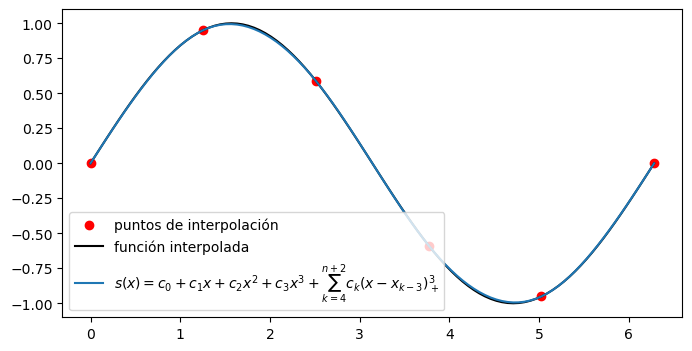

In [50]:
xx = np.linspace(float(x[0]),float(x[-1]),nxx+1)
yy = f_vec(xx)
ss = cc[0]+cc[1]*xx+cc[2]*xx**2+cc[3]*xx**3+sum([cc[k]*potrunc(xx-float(x[k-3]),3) for k in range(4,n+3)])
# Nótes que tanto la función como el spline se están evaluando vectorialmente
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,y,'ro',label='puntos de interpolación')
ax.plot(xx,yy,'k',label='función interpolada')
ax.plot(xx,ss, label='$s(x)= c_0+c_1 x+c_2 x^2+c_3 x^3 +\sum_{k=4}^{n+2} c_k (x-x_{k-3})^3_+$'); 
ax.legend(loc=3);

Si lo que queremos es ir viendo el proceso de construcción del spline cúbico final, a medida que vamos añadiendo más sumandos de su expresión general, podemos realizar una representación gráfica incremental, en la que a cada paso vamos representando la suma parcial correspondiente, obteniéndose el spline final solo en el último paso.

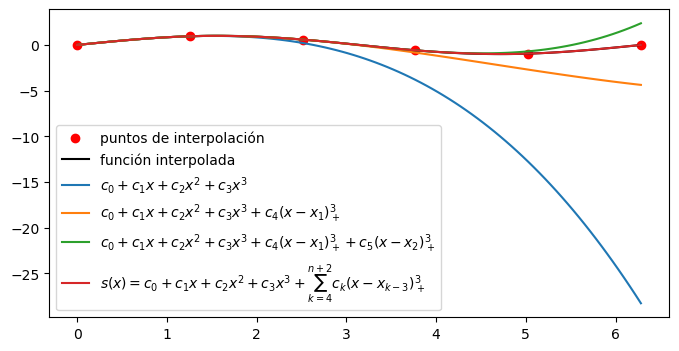

In [51]:
xx = np.linspace(float(x[0]),float(x[-1]),nxx+1)
yy = f_vec(xx)

ss = cc[0]+cc[1]*xx+cc[2]*xx**2+cc[3]*xx**3

fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,y,'ro',label='puntos de interpolación')
ax.plot(xx,yy,'k',label='función interpolada')
ax.plot(xx,ss, label='$ c_0+c_1 x+c_2 x^2+c_3 x^3  $');

ss = ss + cc[4]*potrunc(xx-float(x[1]),3)
ax.plot(xx,ss, label='$ c_0+c_1 x+c_2 x^2+c_3 x^3 + c_4 (x-x_{1})^3_+$');

ss = ss + cc[5]*potrunc(xx-float(x[2]),3)
ax.plot(xx,ss, label='$  c_0+c_1 x+c_2 x^2+c_3 x^3 + c_4 (x-x_{1})^3_+ + c_5 (x-x_{2})^3_+$');

# se representan de manera desacoplada solo los tres primeros términos

ss = cc[0]+cc[1]*xx+cc[2]*xx**2+cc[3]*xx**3+sum([cc[k]*potrunc(xx-float(x[k-3]),3) for k in range(4,n+3)])

ax.plot(xx,ss, label='$s(x)= c_0+c_1 x+c_2 x^2+c_3 x^3 +\sum_{k=4}^{n+2} c_k (x-x_{k-3})^3_+$'); 
ax.legend(loc=0);

¿Se ha conseguido una buena aproximación?

Aparentemente sí, pero podemos representar gráficamente el error cometido para visualizarlo mucho mejor.

In [52]:
x

[0, 2*pi/5, 4*pi/5, 6*pi/5, 8*pi/5, 2*pi]

In [53]:
xa = np.array(x, dtype = float)
xa  # lo convertimos en un array para poder operar elemento a elemento

array([0.        , 1.25663706, 2.51327412, 3.76991118, 5.02654825,
       6.28318531])

In [54]:
sxx = cc[0]+cc[1]*xx+cc[2]*xx**2+cc[3]*xx**3+sum([cc[k]*potrunc(xx-float(x[k-3]),3) for k in range(4,n+3)])
len(sxx)  # esta sería la evaluación del spline en la partición más fina

101

In [55]:
len(yy)

101

In [56]:
sx = cc[0]+cc[1]*xa+cc[2]*xa**2+cc[3]*xa**3+sum([cc[k]*potrunc(xa-float(x[k-3]),3) for k in range(4,n+3)])
len(sx)   # y esta sería la evaluación del spline en los nodos de interpolación

6

In [57]:
len(y)

6

In [58]:
# de esta manera vemos la resta componente a componente de estos valores
sx - np.array(y, dtype = float)  # convertimos y en un array de tipo float
# vemos que los valores no nulos son muy pequeños

array([0,
       -6.85677779444103/pi - 14.2792063659275*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 2.33753788446853*sqrt(2)*sqrt(5 - sqrt(5))/pi**2 + 0.305580545140764 + 7.34359184533417*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 9.13869207419363/pi**2 + 7.0126136534056*sqrt(2)*sqrt(sqrt(5) + 5)/pi**2,
       -88.12310214401*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 27.4271111777641/pi - 9.35015153787413*sqrt(2)*sqrt(5 - sqrt(5))/pi**2 + 1.92548887057936 + 37.1259365514116*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 61.3597896410144/pi**2 + 28.0504546136224*sqrt(2)*sqrt(sqrt(5) + 5)/pi**2,
       -198.276979824023*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 61.7110001499692/pi - 21.0378409602168*sqrt(2)*sqrt(5 - sqrt(5))/pi**2 + 4.35769643660023 + 58.3407574379326*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 156.663292700462/pi**2 + 63.1135228806504*sqrt(2)*sqrt(sqrt(5) + 5)/pi**2,
       -360.243977746115*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 109.708444711056/pi - 37.4006061514965*sqrt(2)*sqrt(5 - sqrt(5))/pi**2 + 5.97760476203882 + 117.497469

In [59]:
# Así, de manera vectorizada podemmos aplicar la función chop 
chop_vec(sx - np.array(y, dtype = float))
# que hace cero todos estos pequeños errores de redondeo.

array([0, 0, 0, 0, 0, 0])

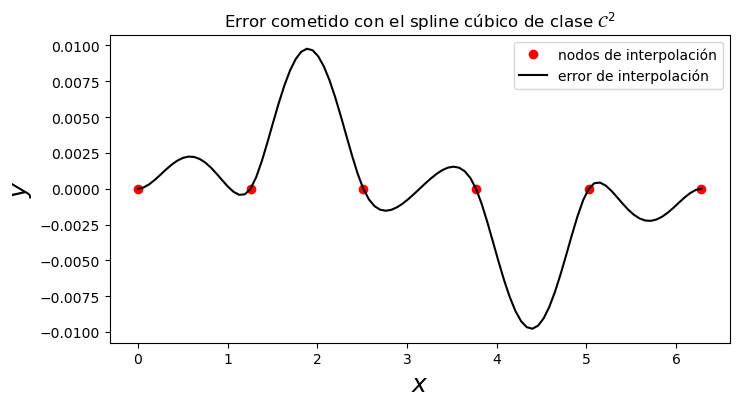

In [60]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,np.zeros(len(x)),'ro',label='nodos de interpolación')
ax.plot(xx,yy-ss,'k',label='error de interpolación')
# en caso necesario, para intentar mejorar la visualización
ax.legend(loc=1)   # se puede cambiar este localizador
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Error cometido con el spline cúbico de clase $\mathcal{C}^2$');

### Caso cúbico natural $s''(x_0) = 0 = s''(x_n)$.

De manera totalmente análoga al caso sujeto se obtendría ahora el caso cúbico natural, sin más que cambiar las dos ecuaciones adicionales en los extremos del intervalo por la nuevas condiciones sobre anulación de la segunda derivada en ambos extremos.

In [61]:
m = n+3
c = sp.symbols('c_:%d' % m) 

In [62]:
c

(c_0, c_1, c_2, c_3, c_4, c_5, c_6, c_7)

In [63]:
s = c[0] + c[1]*z + c[2]*z**2 + c[3]*z**3
s

c_0 + c_1*z + c_2*z**2 + c_3*z**3

In [64]:
d2s = sp.diff(s,z,2)  # ahora necesitaríamos obtener la segunda derivada
d2s

2*(c_2 + 3*c_3*z)

In [65]:
ecnatizda = sp.Eq(d2s.subs({z:x[0]}),0)  # e igualarla a cero en el extremo
ecnatizda                                # izquierdo del intervalo

Eq(2*c_2, 0)

In [66]:
ecs =[ecnatizda ]

In [67]:
ec0 = sp.Eq(s.subs({z:x[0]}),y[0])
ecs.append(ec0)

ec1 = sp.Eq(s.subs({z:x[1]}),y[1])
ecs.append(ec1)

for k in range(1,n):
    s = s + c[k+3]*(z-x[k])**3
    eck = sp.Eq(s.subs({z:x[k+1]}),y[k+1])
    ecs.append(eck)
    
ecs

[Eq(2*c_2, 0),
 Eq(c_0, 0),
 Eq(c_0 + 2*pi*c_1/5 + 4*pi**2*c_2/25 + 8*pi**3*c_3/125, sqrt(sqrt(5)/8 + 5/8)),
 Eq(c_0 + 4*pi*c_1/5 + 16*pi**2*c_2/25 + 64*pi**3*c_3/125 + 8*pi**3*c_4/125, sqrt(5/8 - sqrt(5)/8)),
 Eq(c_0 + 6*pi*c_1/5 + 36*pi**2*c_2/25 + 216*pi**3*c_3/125 + 64*pi**3*c_4/125 + 8*pi**3*c_5/125, -sqrt(5/8 - sqrt(5)/8)),
 Eq(c_0 + 8*pi*c_1/5 + 64*pi**2*c_2/25 + 512*pi**3*c_3/125 + 216*pi**3*c_4/125 + 64*pi**3*c_5/125 + 8*pi**3*c_6/125, -sqrt(sqrt(5)/8 + 5/8)),
 Eq(c_0 + 2*pi*c_1 + 4*pi**2*c_2 + 8*pi**3*c_3 + 512*pi**3*c_4/125 + 216*pi**3*c_5/125 + 64*pi**3*c_6/125 + 8*pi**3*c_7/125, 0)]

In [68]:
ecs[-1]

Eq(c_0 + 2*pi*c_1 + 4*pi**2*c_2 + 8*pi**3*c_3 + 512*pi**3*c_4/125 + 216*pi**3*c_5/125 + 64*pi**3*c_6/125 + 8*pi**3*c_7/125, 0)

In [69]:
s   # Sería la expresión del spline en el último subintervalo de la partición 

c_0 + c_1*z + c_2*z**2 + c_3*z**3 + c_4*(z - 2*pi/5)**3 + c_5*(z - 4*pi/5)**3 + c_6*(z - 6*pi/5)**3 + c_7*(z - 8*pi/5)**3

In [70]:
d2s = sp.diff(s,z,2)  # volvemos a calcular simbólicamente 
d2s                   # la derivada segunda considerando todos los términos

2*(c_2 + 3*c_3*z + 3*c_4*(5*z - 2*pi)/5 + 3*c_5*(5*z - 4*pi)/5 + 3*c_6*(5*z - 6*pi)/5 + 3*c_7*(5*z - 8*pi)/5)

In [71]:
ecnatdcha = sp.Eq(d2s.subs({z:x[-1]}),0)  # e igualarla a cero en el extremo
ecnatdcha                                 # derecho del intervalo

Eq(2*c_2 + 12*pi*c_3 + 48*pi*c_4/5 + 36*pi*c_5/5 + 24*pi*c_6/5 + 12*pi*c_7/5, 0)

In [72]:
 ecs.append(ecnatdcha)  # y terminamos de añadir esta útima ecuación
# a la lista de ecuaciones anteriores impuestas para este tipo de spline

In [73]:
sols = sp.solve(ecs,c)  # cuya soluciones se obtienen con solve de Sympy

In [74]:
sols                    # en formato diccionario de Python, en principio

{c_0: 0,
 c_1: -15*sqrt(2)*sqrt(5 - sqrt(5))/(44*pi) + 45*sqrt(2)*sqrt(sqrt(5) + 5)/(44*pi),
 c_2: 0,
 c_3: -875*sqrt(2)*sqrt(sqrt(5) + 5)/(352*pi**3) + 375*sqrt(2)*sqrt(5 - sqrt(5))/(176*pi**3),
 c_4: -3125*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3) + 625*sqrt(2)*sqrt(sqrt(5) + 5)/(88*pi**3),
 c_5: -3125*sqrt(2)*sqrt(sqrt(5) + 5)/(352*pi**3) + 5625*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3),
 c_6: -5625*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3) + 3125*sqrt(2)*sqrt(sqrt(5) + 5)/(352*pi**3),
 c_7: -625*sqrt(2)*sqrt(sqrt(5) + 5)/(88*pi**3) + 3125*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3)}

In [75]:
# que podremos usar a continuación para guardarlas en una lista de Python
cc = [c[k].subs(sols) for k in range(len(c))]

In [76]:
cc    # que hemos denominado cc

[0,
 -15*sqrt(2)*sqrt(5 - sqrt(5))/(44*pi) + 45*sqrt(2)*sqrt(sqrt(5) + 5)/(44*pi),
 0,
 -875*sqrt(2)*sqrt(sqrt(5) + 5)/(352*pi**3) + 375*sqrt(2)*sqrt(5 - sqrt(5))/(176*pi**3),
 -3125*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3) + 625*sqrt(2)*sqrt(sqrt(5) + 5)/(88*pi**3),
 -3125*sqrt(2)*sqrt(sqrt(5) + 5)/(352*pi**3) + 5625*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3),
 -5625*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3) + 3125*sqrt(2)*sqrt(sqrt(5) + 5)/(352*pi**3),
 -625*sqrt(2)*sqrt(sqrt(5) + 5)/(88*pi**3) + 3125*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3)]

A continuación, podremos representar gráficamente este spline cúbico natural obtenido, sin más que evaluarlo en una partición del intervalo lo suficientemente fina, como para que no parezca una poligonal.

In [77]:
nxx    # este valor indicará el número de subintervalos de la partición

100

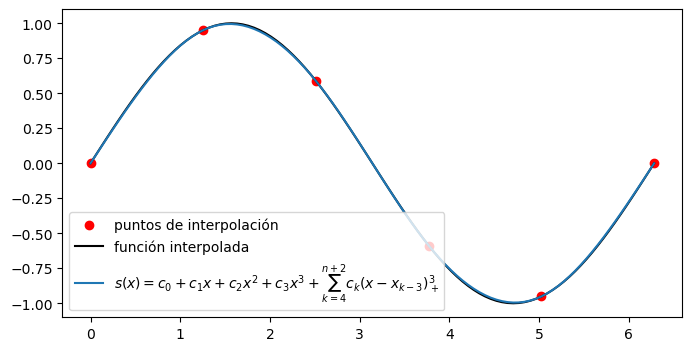

In [78]:
xx = np.linspace(float(x[0]),float(x[-1]),nxx+1)
yy = f_vec(xx)
ss = cc[0]+cc[1]*xx+cc[2]*xx**2+cc[3]*xx**3+sum([cc[k]*potrunc(xx-float(x[k-3]),3) for k in range(4,n+3)])
# Nótese que tanto la función como el spline se evaluaron vectorialmente
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,y,'ro',label='puntos de interpolación')
ax.plot(xx,yy,'k',label='función interpolada')
ax.plot(xx,ss, label='$s(x)= c_0+c_1 x+c_2 x^2+c_3 x^3 +\sum_{k=4}^{n+2} c_k (x-x_{k-3})^3_+$'); 
ax.legend(loc=3);

Si lo que queremos es ir viendo el proceso de construcción del spline cúbico final, a medida que vamos añadiendo más sumandos de su expresión general, podemos realizar una representación gráfica incremental, en la que a cada paso vamos representando la suma parcial correspondiente, obteniéndose el spline final solo en el último paso.

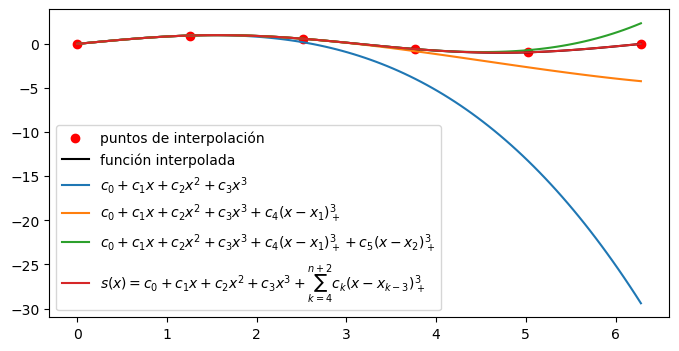

In [79]:
xx = np.linspace(float(x[0]),float(x[-1]),nxx+1)
yy = f_vec(xx)

ss = cc[0]+cc[1]*xx+cc[2]*xx**2+cc[3]*xx**3

fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,y,'ro',label='puntos de interpolación')
ax.plot(xx,yy,'k',label='función interpolada')
ax.plot(xx,ss, label='$ c_0+c_1 x+c_2 x^2+c_3 x^3  $');

ss = ss + cc[4]*potrunc(xx-float(x[1]),3)
ax.plot(xx,ss, label='$ c_0+c_1 x+c_2 x^2+c_3 x^3 + c_4 (x-x_{1})^3_+$');

ss = ss + cc[5]*potrunc(xx-float(x[2]),3)
ax.plot(xx,ss, label='$  c_0+c_1 x+c_2 x^2+c_3 x^3 + c_4 (x-x_{1})^3_+ + c_5 (x-x_{2})^3_+$');

# se representan de manera desacoplada solo los tres primeros términos


ss = cc[0]+cc[1]*xx+cc[2]*xx**2+cc[3]*xx**3+sum([cc[k]*potrunc(xx-float(x[k-3]),3) for k in range(4,n+3)])

ax.plot(xx,ss, label='$s(x)= c_0+c_1 x+c_2 x^2+c_3 x^3 +\sum_{k=4}^{n+2} c_k (x-x_{k-3})^3_+$'); 
ax.legend(loc=0);

¿Se ha conseguido una buena aproximación?

Aparentemente sí, pero podemos representar gráficamente el error cometido para visualizarlo mucho mejor.

In [80]:
xa = np.array(x, dtype = float)
xa  # lo convertimos en un array para poder operar elemento a elemento

array([0.        , 1.25663706, 2.51327412, 3.76991118, 5.02654825,
       6.28318531])

In [81]:
xx

array([0.        , 0.06283185, 0.12566371, 0.18849556, 0.25132741,
       0.31415927, 0.37699112, 0.43982297, 0.50265482, 0.56548668,
       0.62831853, 0.69115038, 0.75398224, 0.81681409, 0.87964594,
       0.9424778 , 1.00530965, 1.0681415 , 1.13097336, 1.19380521,
       1.25663706, 1.31946891, 1.38230077, 1.44513262, 1.50796447,
       1.57079633, 1.63362818, 1.69646003, 1.75929189, 1.82212374,
       1.88495559, 1.94778745, 2.0106193 , 2.07345115, 2.136283  ,
       2.19911486, 2.26194671, 2.32477856, 2.38761042, 2.45044227,
       2.51327412, 2.57610598, 2.63893783, 2.70176968, 2.76460154,
       2.82743339, 2.89026524, 2.95309709, 3.01592895, 3.0787608 ,
       3.14159265, 3.20442451, 3.26725636, 3.33008821, 3.39292007,
       3.45575192, 3.51858377, 3.58141563, 3.64424748, 3.70707933,
       3.76991118, 3.83274304, 3.89557489, 3.95840674, 4.0212386 ,
       4.08407045, 4.1469023 , 4.20973416, 4.27256601, 4.33539786,
       4.39822972, 4.46106157, 4.52389342, 4.58672527, 4.64955

In [82]:
sxx = cc[0]+cc[1]*xx+cc[2]*xx**2+cc[3]*xx**3+sum([cc[k]*potrunc(xx-float(x[k-3]),3) for k in range(4,n+3)])
sxx

array([0,
       -0.0214199499108395*sqrt(2)*sqrt(5 - sqrt(5))/pi - 0.000616602093074144*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 + 0.000528516079777838*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 0.0642598497325185*sqrt(2)*sqrt(sqrt(5) + 5)/pi,
       -0.042839899821679*sqrt(2)*sqrt(5 - sqrt(5))/pi - 0.00493281674459315*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 + 0.0042281286382227*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 0.128519699465037*sqrt(2)*sqrt(sqrt(5) + 5)/pi,
       -0.0642598497325185*sqrt(2)*sqrt(5 - sqrt(5))/pi - 0.0166482565130019*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 + 0.0142699341540016*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 0.192779549197555*sqrt(2)*sqrt(sqrt(5) + 5)/pi,
       -0.085679799643358*sqrt(2)*sqrt(5 - sqrt(5))/pi - 0.0394625339567452*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 + 0.0338250291057816*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 0.257039398930074*sqrt(2)*sqrt(sqrt(5) + 5)/pi,
       -0.107099749554197*sqrt(2)*sqrt(5 - sqrt(5))/pi - 0.077075261634268*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 + 0.0660645099722297*sqrt(2)*sq

In [83]:
sx = cc[0]+cc[1]*xa+cc[2]*xa**2+cc[3]*xa**3+sum([cc[k]*potrunc(xa-float(x[k-3]),3) for k in range(4,n+3)])
sx

array([0,
       -4.93281674459315*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 0.42839899821679*sqrt(2)*sqrt(5 - sqrt(5))/pi + 4.2281286382227*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 1.28519699465037*sqrt(2)*sqrt(sqrt(5) + 5)/pi,
       -25.3687718293362*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 0.85679799643358*sqrt(2)*sqrt(5 - sqrt(5))/pi + 16.2078264465204*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 2.57039398930074*sqrt(2)*sqrt(sqrt(5) + 5)/pi,
       -38.0531577440043*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 1.28519699465037*sqrt(2)*sqrt(5 - sqrt(5))/pi + 4.9328167445932*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 3.85559098395111*sqrt(2)*sqrt(sqrt(5) + 5)/pi,
       -58.4891128287473*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 1.71359599286716*sqrt(2)*sqrt(5 - sqrt(5))/pi + 16.9125145528908*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 5.14078797860148*sqrt(2)*sqrt(sqrt(5) + 5)/pi,
       -63.4219295733407*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 2.14199499108395*sqrt(2)*sqrt(5 - sqrt(5))/pi + 21.1406431911139*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 6.425984973251

In [84]:
# Así comprobamos que se verifican las condiciones de interpolación
chop_vec(sx - np.array(y, dtype = float))   # lagrangianas

array([0, 0, 0, 0, 0, 0])

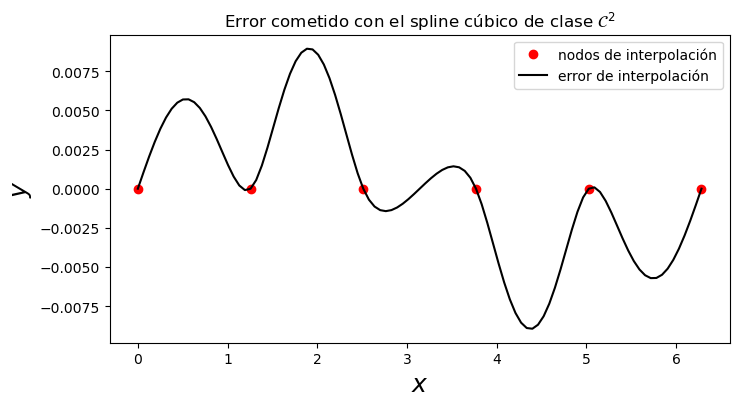

In [85]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,np.zeros(len(x)),'ro',label='nodos de interpolación')
ax.plot(xx,yy-ss,'k',label='error de interpolación')
# en caso necesario, para intentar mejorar la visualización
ax.legend(loc=1)   # se puede cambiar este localizador
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Error cometido con el spline cúbico de clase $\mathcal{C}^2$');

### Caso cúbico periódico $s'(x_0) = s'(x_n)$   y   $s''(x_0) = s''(x_n)$.

Ahora en el caso cúbico periódico, tendremos que considerar las dos condiciones adicionales indicadas justo más arriba, aparte de las de tipo lagrangiano ya habituales.

In [86]:
m = n+3
c = sp.symbols('c_:%d' % m) 

In [87]:
c

(c_0, c_1, c_2, c_3, c_4, c_5, c_6, c_7)

In [88]:
s = c[0] + c[1]*z + c[2]*z**2 + c[3]*z**3
s

c_0 + c_1*z + c_2*z**2 + c_3*z**3

In [89]:
ds = sp.diff(s,z)  # empezamos calculando simbólicamente la derivada primera
ds

c_1 + 2*c_2*z + 3*c_3*z**2

In [90]:
condper1izda = ds.subs({z:x[0]}) # y evaluándola en el nodo del extremo izdo.
condper1izda

c_1

In [91]:
d2s = sp.diff(s,z,2)   # ahora calculamos igualmente la derivada segunda
d2s

2*(c_2 + 3*c_3*z)

In [92]:
condper2izda = d2s.subs({z:x[0]}) # y la evaluamos también en ese nodo
condper2izda

2*c_2

In [93]:
# Y como en este caso aún no tenemos ninguna ecuación bien formada
ecs = []     # empezaremos con una lista de ecuaciones vacía

In [94]:
# que empezaremos a llenar con las condiciones de tipo Lagrange
ec0 = sp.Eq(s.subs({z:x[0]}),y[0])    # en el extremo de la izquierda
ecs.append(ec0)

ec1 = sp.Eq(s.subs({z:x[1]}),y[1])    # el nodo derecho del primer subintervalo
ecs.append(ec1)

for k in range(1,n):                  # y ya con el resto de la partición
    s = s + c[k+3]*(z-x[k])**3
    eck = sp.Eq(s.subs({z:x[k+1]}),y[k+1])
    ecs.append(eck)
    
ecs   # lista de ecuaciones asociadas a condiciones de tipo Lagrange

[Eq(c_0, 0),
 Eq(c_0 + 2*pi*c_1/5 + 4*pi**2*c_2/25 + 8*pi**3*c_3/125, sqrt(sqrt(5)/8 + 5/8)),
 Eq(c_0 + 4*pi*c_1/5 + 16*pi**2*c_2/25 + 64*pi**3*c_3/125 + 8*pi**3*c_4/125, sqrt(5/8 - sqrt(5)/8)),
 Eq(c_0 + 6*pi*c_1/5 + 36*pi**2*c_2/25 + 216*pi**3*c_3/125 + 64*pi**3*c_4/125 + 8*pi**3*c_5/125, -sqrt(5/8 - sqrt(5)/8)),
 Eq(c_0 + 8*pi*c_1/5 + 64*pi**2*c_2/25 + 512*pi**3*c_3/125 + 216*pi**3*c_4/125 + 64*pi**3*c_5/125 + 8*pi**3*c_6/125, -sqrt(sqrt(5)/8 + 5/8)),
 Eq(c_0 + 2*pi*c_1 + 4*pi**2*c_2 + 8*pi**3*c_3 + 512*pi**3*c_4/125 + 216*pi**3*c_5/125 + 64*pi**3*c_6/125 + 8*pi**3*c_7/125, 0)]

In [95]:
s  # y esta sería la expresión general del spline cúbico completo

c_0 + c_1*z + c_2*z**2 + c_3*z**3 + c_4*(z - 2*pi/5)**3 + c_5*(z - 4*pi/5)**3 + c_6*(z - 6*pi/5)**3 + c_7*(z - 8*pi/5)**3

In [96]:
ds = sp.diff(s,z)  # que tendremos también que derivar simbólicamente
ds

c_1 + 2*c_2*z + 3*c_3*z**2 + 3*c_4*(z - 2*pi/5)**2 + 3*c_5*(z - 4*pi/5)**2 + 3*c_6*(z - 6*pi/5)**2 + 3*c_7*(z - 8*pi/5)**2

In [98]:
condper1dcha = ds.subs({z:x[-1]}) # y evaluar en el extremo derecho
condper1dcha

c_1 + 4*pi*c_2 + 12*pi**2*c_3 + 192*pi**2*c_4/25 + 108*pi**2*c_5/25 + 48*pi**2*c_6/25 + 12*pi**2*c_7/25

In [99]:
ecperiod1 = sp.Eq(condper1izda,condper1dcha)  # para igualar al izqudo.
ecperiod1        # y obtener la primera ecuación adicional a considerar

Eq(c_1, c_1 + 4*pi*c_2 + 12*pi**2*c_3 + 192*pi**2*c_4/25 + 108*pi**2*c_5/25 + 48*pi**2*c_6/25 + 12*pi**2*c_7/25)

In [100]:
 ecs.append(ecperiod1)   # que se añade finalmente a la lista ya obtenida

In [101]:
d2s = sp.diff(s,z,2)     # haremos esto mismo con las derivadas segunda
d2s

2*(c_2 + 3*c_3*z + 3*c_4*(5*z - 2*pi)/5 + 3*c_5*(5*z - 4*pi)/5 + 3*c_6*(5*z - 6*pi)/5 + 3*c_7*(5*z - 8*pi)/5)

In [102]:
condper2dcha = d2s.subs({z:x[-1]})  # evaluada en el extremo de la dcha.
condper2dcha

2*c_2 + 12*pi*c_3 + 48*pi*c_4/5 + 36*pi*c_5/5 + 24*pi*c_6/5 + 12*pi*c_7/5

In [103]:
ecperiod2 = sp.Eq(condper2izda,condper2dcha) # igualado al de la izda.
ecperiod2

Eq(2*c_2, 2*c_2 + 12*pi*c_3 + 48*pi*c_4/5 + 36*pi*c_5/5 + 24*pi*c_6/5 + 12*pi*c_7/5)

In [104]:
 ecs.append(ecperiod2)    # que se añada a la lista ya obtenida

In [105]:
sols = sp.solve(ecs,c)    # y se resuelve de la manera habitual

In [106]:
sols                      # obteniendo las soluciones en formato diccionario

{c_0: 0,
 c_1: -15*sqrt(2)*sqrt(5 - sqrt(5))/(44*pi) + 45*sqrt(2)*sqrt(sqrt(5) + 5)/(44*pi),
 c_2: 0,
 c_3: -875*sqrt(2)*sqrt(sqrt(5) + 5)/(352*pi**3) + 375*sqrt(2)*sqrt(5 - sqrt(5))/(176*pi**3),
 c_4: -3125*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3) + 625*sqrt(2)*sqrt(sqrt(5) + 5)/(88*pi**3),
 c_5: -3125*sqrt(2)*sqrt(sqrt(5) + 5)/(352*pi**3) + 5625*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3),
 c_6: -5625*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3) + 3125*sqrt(2)*sqrt(sqrt(5) + 5)/(352*pi**3),
 c_7: -625*sqrt(2)*sqrt(sqrt(5) + 5)/(88*pi**3) + 3125*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3)}

In [107]:
cc = [c[k].subs(sols) for k in range(len(c))] # ahora como una lista

In [108]:
cc    # cuyos valores podemos ver y extraer cuando necesitemos

[0,
 -15*sqrt(2)*sqrt(5 - sqrt(5))/(44*pi) + 45*sqrt(2)*sqrt(sqrt(5) + 5)/(44*pi),
 0,
 -875*sqrt(2)*sqrt(sqrt(5) + 5)/(352*pi**3) + 375*sqrt(2)*sqrt(5 - sqrt(5))/(176*pi**3),
 -3125*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3) + 625*sqrt(2)*sqrt(sqrt(5) + 5)/(88*pi**3),
 -3125*sqrt(2)*sqrt(sqrt(5) + 5)/(352*pi**3) + 5625*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3),
 -5625*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3) + 3125*sqrt(2)*sqrt(sqrt(5) + 5)/(352*pi**3),
 -625*sqrt(2)*sqrt(sqrt(5) + 5)/(88*pi**3) + 3125*sqrt(2)*sqrt(5 - sqrt(5))/(352*pi**3)]

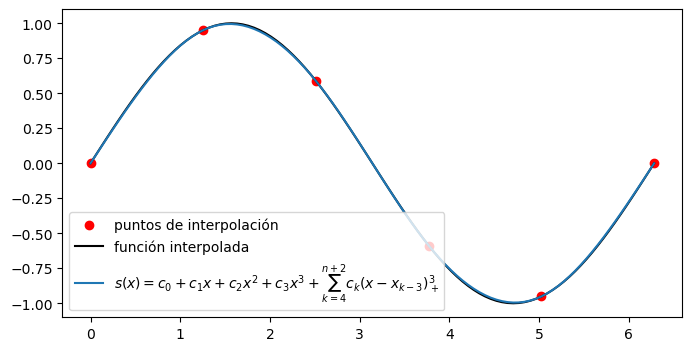

In [109]:
xx = np.linspace(float(x[0]),float(x[-1]),nxx+1)
yy = f_vec(xx)
ss = cc[0]+cc[1]*xx+cc[2]*xx**2+cc[3]*xx**3+sum([cc[k]*potrunc(xx-float(x[k-3]),3) for k in range(4,n+3)])
# Nótese que tanto la función como el spline se han evaluado vectorialmente
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,y,'ro',label='puntos de interpolación')
ax.plot(xx,yy,'k',label='función interpolada')
ax.plot(xx,ss, label='$s(x)= c_0+c_1 x+c_2 x^2+c_3 x^3 +\sum_{k=4}^{n+2} c_k (x-x_{k-3})^3_+$'); 
ax.legend(loc=3);

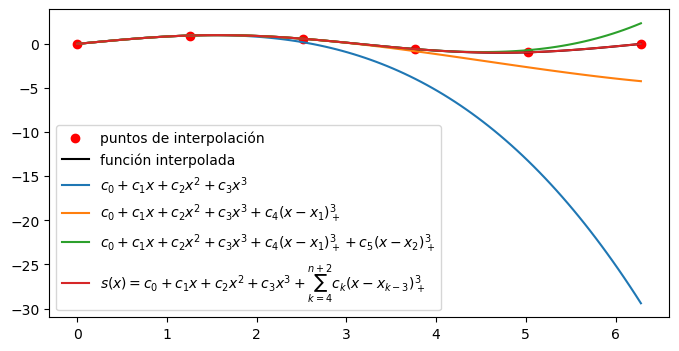

In [110]:
xx = np.linspace(float(x[0]),float(x[-1]),nxx+1)
yy = f_vec(xx)

ss = cc[0]+cc[1]*xx+cc[2]*xx**2+cc[3]*xx**3

fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,y,'ro',label='puntos de interpolación')
ax.plot(xx,yy,'k',label='función interpolada')
ax.plot(xx,ss, label='$ c_0+c_1 x+c_2 x^2+c_3 x^3  $');

ss = ss + cc[4]*potrunc(xx-float(x[1]),3)
ax.plot(xx,ss, label='$ c_0+c_1 x+c_2 x^2+c_3 x^3 + c_4 (x-x_{1})^3_+$');

ss = ss + cc[5]*potrunc(xx-float(x[2]),3)
ax.plot(xx,ss, label='$  c_0+c_1 x+c_2 x^2+c_3 x^3 + c_4 (x-x_{1})^3_+ + c_5 (x-x_{2})^3_+$');

# sólo los primeros términos se ha desacoplado para representarlos gráficamente

ss = cc[0]+cc[1]*xx+cc[2]*xx**2+cc[3]*xx**3+sum([cc[k]*potrunc(xx-float(x[k-3]),3) for k in range(4,n+3)])

ax.plot(xx,ss, label='$s(x)= c_0+c_1 x+c_2 x^2+c_3 x^3 +\sum_{k=4}^{n+2} c_k (x-x_{k-3})^3_+$'); 
ax.legend(loc=0);

¿Se ha conseguido una buena aproximación?

Aparentemente sí, pero podemos representar gráficamente el error cometido para visualizarlo mucho mejor.

In [111]:
xa = np.array(x, dtype = float)
xa  # lo convertimos en un array para poder operar elemento a elemento

array([0.        , 1.25663706, 2.51327412, 3.76991118, 5.02654825,
       6.28318531])

In [112]:
sx = cc[0]+cc[1]*xa+cc[2]*xa**2+cc[3]*xa**3+sum([cc[k]*potrunc(xa-float(x[k-3]),3) for k in range(4,n+3)])
sx

array([0,
       -4.93281674459315*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 0.42839899821679*sqrt(2)*sqrt(5 - sqrt(5))/pi + 4.2281286382227*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 1.28519699465037*sqrt(2)*sqrt(sqrt(5) + 5)/pi,
       -25.3687718293362*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 0.85679799643358*sqrt(2)*sqrt(5 - sqrt(5))/pi + 16.2078264465204*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 2.57039398930074*sqrt(2)*sqrt(sqrt(5) + 5)/pi,
       -38.0531577440043*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 1.28519699465037*sqrt(2)*sqrt(5 - sqrt(5))/pi + 4.9328167445932*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 3.85559098395111*sqrt(2)*sqrt(sqrt(5) + 5)/pi,
       -58.4891128287473*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 1.71359599286716*sqrt(2)*sqrt(5 - sqrt(5))/pi + 16.9125145528908*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 5.14078797860148*sqrt(2)*sqrt(sqrt(5) + 5)/pi,
       -63.4219295733407*sqrt(2)*sqrt(sqrt(5) + 5)/pi**3 - 2.14199499108395*sqrt(2)*sqrt(5 - sqrt(5))/pi + 21.1406431911139*sqrt(2)*sqrt(5 - sqrt(5))/pi**3 + 6.425984973251

In [113]:
chop_vec(sx - np.array(y, dtype = float))

array([0, 0, 0, 0, 0, 0])

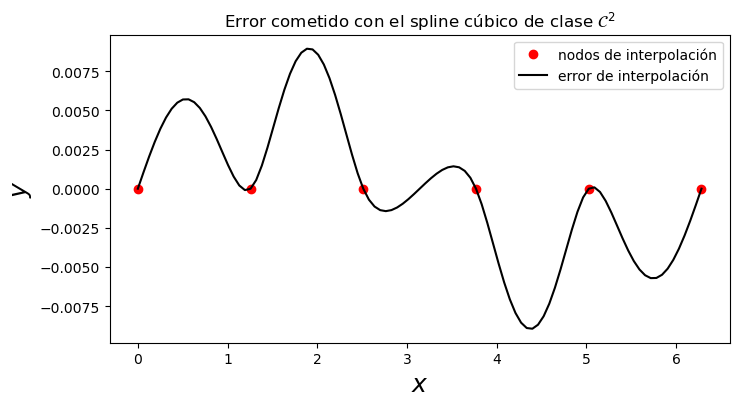

In [114]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,np.zeros(len(x)),'ro',label='nodos de interpolación')
ax.plot(xx,yy-ss,'k',label='error de interpolación')
# en caso necesario, para intentar mejorar la visualización
ax.legend(loc=1)   # se puede cambiar este localizador
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Error cometido con el spline cúbico de clase $\mathcal{C}^2$');

# Otros planteamientos a partir de las ecuaciones genéricas de los trozos de cúbicas

Para obtener un *spline cúbico* de interpolación como este, la restricción del spline $s(x)$ al correspondiente subintervalo $[x_{k-1},x_{k}]$ se podría expresar
como 

$$
s_k(x) \equiv  y_{k-1} + d_{k-1}(x - x_{k-1}) + \frac{(-d_{k-1} + Δ_{k})(x - x_{k-1})^2}{h_{k}} + (x - x_{k-1})^2(x - x_{k})\frac{(d_{k-1} + d_{k} - 2 Δ_{k})}{h_{k}^2}
$$

donde $h_k=x_{k}-x_{k-1}$ y  $\Delta_k=\frac{y_{k}-y_{k-1}}{h_k}$. 

Hay que calcular los valores $d_k$, con $k\in\{ 0,1,\ldots,n\}$. Para ello determinamos las *amplitudes* $h_k$ y los *cocientes incrementales* $\Delta _k$, con los que formaremos otras dos listas (`h`, $\Delta$ respectivamente).

In [115]:
x

[0, 2*pi/5, 4*pi/5, 6*pi/5, 8*pi/5, 2*pi]

In [116]:
len(x), n

(6, 5)

In [117]:
h = {k:x[k]-x[k-1] for k in range(1,n+1)} # Así se tendría resuelto el problema
h     # de los índices que queramos que empiecen en 1, en vez de en 0

{1: 2*pi/5, 2: 2*pi/5, 3: 2*pi/5, 4: 2*pi/5, 5: 2*pi/5}

In [118]:
h[1], h[2], h[3]

(2*pi/5, 2*pi/5, 2*pi/5)

In [119]:
Δ = {k:float((y[k]-y[k-1])/h[k]) for k in range(1,n+1)}
Δ

{1: 0.7568267286406569,
 2: -0.28908208674633745,
 3: -0.935489283788639,
 4: -0.28908208674633745,
 5: 0.7568267286406569}

En general, disponemos de $n-1$ ecuaciones (una por cada nodo interior de la partición) 

$$\frac{d_{k}}{h_{k}} + d_{k+1} \left(\frac{2}{h_{k+1}} + \frac{2}{h_{k}}\right) + \frac{d_{k+2}}{h_{k+1}} = \frac{3 Δ_{k+1}}{h_{k+1}} + \frac{3 Δ_{k}}{h_{k}}$$

para un total de  $n+1$ incógnitas; en este caso: $d_0, d_1, \ldots, d_n$. Debemos pues añadir las dos ecuaciones adicionales que vendrán asociadas al tipo de spline cúbico que consideremos: natural, periódico o sujeto.

### Caso cúbico sujeto: $s'(x_0) = d_0 = f'(x_0)$   y   $s'(x_n) = d_n = f'(x_n)$.

Empecemos con el caso cúbico sujeto, que sería el más fácil de resolver para este planteamiento concreto, ya que simplemente supondría asumir conocidos los valores extremos de la derivada primera: $d_0$ y $d_n$, quedando los restantes valores como incógnitas que tendremos que calcular. 

**Nota**: Si no se conociera la función de partida $f$, o bien no fuera posible obtener su derivada simbóliciamente, al menos nos deberían de dar estos valores $d_0$ y $d_n$, que podrían ser simples estimaciones de las correspondientes derivadas.

In [120]:
df(z)

cos(z)

In [121]:
d0 = float(df(x[0]))
dn = float(df(x[-1]))

In [122]:
d0, dn

(1.0, 1.0)

In [123]:
from numpy import matrix, zeros

In [124]:
?zeros

In [125]:
A = matrix(zeros((n-1,n-1),dtype = float))
A

matrix([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [126]:
n

5

In [127]:
h

{1: 2*pi/5, 2: 2*pi/5, 3: 2*pi/5, 4: 2*pi/5, 5: 2*pi/5}

In [128]:
Δ

{1: 0.7568267286406569,
 2: -0.28908208674633745,
 3: -0.935489283788639,
 4: -0.28908208674633745,
 5: 0.7568267286406569}

In [129]:
for k in range(1,n):
    A[k-1,k-1] = 2/h[k]+2/h[k+1]
for k in range(1,n-1):
    A[k-1,k] = A[k,k-1] = 1/h[k+1]

In [130]:
A

matrix([[3.18309886, 0.79577472, 0.        , 0.        ],
        [0.79577472, 3.18309886, 0.79577472, 0.        ],
        [0.        , 0.79577472, 3.18309886, 0.79577472],
        [0.        , 0.        , 0.79577472, 3.18309886]])

In [131]:
B = matrix(zeros((1,n-1),dtype = float)).T
B

matrix([[0.],
        [0.],
        [0.],
        [0.]])

In [132]:
Δ

{1: 0.7568267286406569,
 2: -0.28908208674633745,
 3: -0.935489283788639,
 4: -0.28908208674633745,
 5: 0.7568267286406569}

In [133]:
B[0] = 3*(Δ[1]/h[1]+Δ[2]/h[2])-d0/h[1]
for k in range(1,n-2):
    B[k] = 3*(Δ[k+1]/h[k+1]+Δ[k+2]/h[k+2])
B[3] = 3*(Δ[4]/h[4]+Δ[5]/h[5])-dn/h[5]

In [134]:
B

matrix([[ 0.32088336],
        [-2.9234488 ],
        [-2.9234488 ],
        [ 0.32088336]])

Y ya tan solo habrá que terminar de resolver el corrrespondiente sistema lineal construido.

In [135]:
from numpy.linalg import solve

In [136]:
D = solve(A,B)

In [137]:
D[0], D[3]

(matrix([[0.29946757]]), matrix([[0.29946757]]))

In [138]:
D = np.array(D)
D

array([[ 0.29946757],
       [-0.79463634],
       [-0.79463634],
       [ 0.29946757]])

Para comparar la bondad de la aproximación representamos la función interpolada y mostramos su gráfica y la del spline de interpolación.

In [139]:
D = D.tolist()

In [140]:
d = [D[k][0] for k in range(len(D))]

In [141]:
d.insert(0,d0)
d.append(dn)
d

[1.0,
 0.2994675652641959,
 -0.7946363353738252,
 -0.794636335373825,
 0.2994675652641958,
 1.0]

In [142]:
nxx

100

In [143]:
nzz = nxx//(n+1)

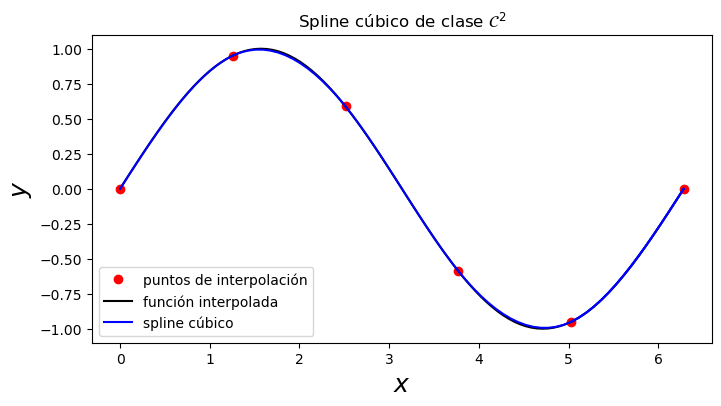

In [144]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,y,'ro',label='puntos de interpolación')
ax.plot(xx,yy,'k',label='función interpolada')
for k in range(1,n+1):
    zz = np.linspace(float(x[k-1]),float(x[k]),nzz)
    yk = [cubicaconderivadas(z,x[k-1],y[k-1],d[k-1],x[k],y[k],d[k]) 
          for z in zz]
    plt.plot(zz,yk,'b');
# A continuación volvemos a repetir el último trozo para que
plt.plot(zz,yk,'b',label='spline cúbico') # aparezca la leyenda
# en caso necesario, para intentar mejorar la visualización
ax.legend(loc=3)   # se puede cambiar este localizador
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Spline cúbico de clase $\mathcal{C}^2$');

Representemos ahora más bien el error cometido

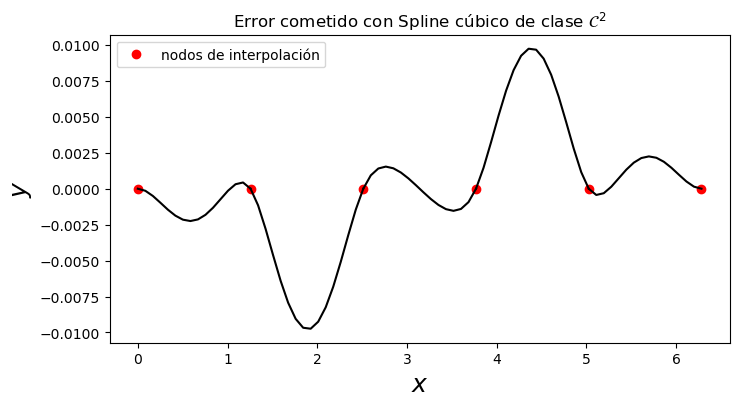

In [145]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(x,np.zeros(len(x)),'ro',label='nodos de interpolación')
# ax.plot(x,y,'ro',label='puntos de interpolación')
# ax.plot(xx,yy,'k',label='función interpolada')
for k in range(1,n+1):
    zz = np.linspace(float(x[k-1]),float(x[k]),nzz)
    fk = f_vec(zz)
    yk = [cubicaconderivadas(z,x[k-1],y[k-1],d[k-1],x[k],y[k],d[k]) 
          for z in zz]
    plt.plot(zz,yk-fk,'k');
# A continuación volvemos a repetir el último trozo para que
# plt.plot(zz,yk,'b',label='spline cúbico') # aparezca la leyenda
# en caso necesario, para intentar mejorar la visualización
ax.legend(loc=2)   # se puede cambiar este localizador
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18)
ax.set_title('Error cometido con Spline cúbico de clase $\mathcal{C}^2$');

## Usando la orden `interpolate` del módulo `SciPy`

In [146]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

print(x,y)

[0, 2*pi/5, 4*pi/5, 6*pi/5, 8*pi/5, 2*pi] [0 sqrt(sqrt(5)/8 + 5/8) sqrt(5/8 - sqrt(5)/8) -sqrt(5/8 - sqrt(5)/8)
 -sqrt(sqrt(5)/8 + 5/8) 0]


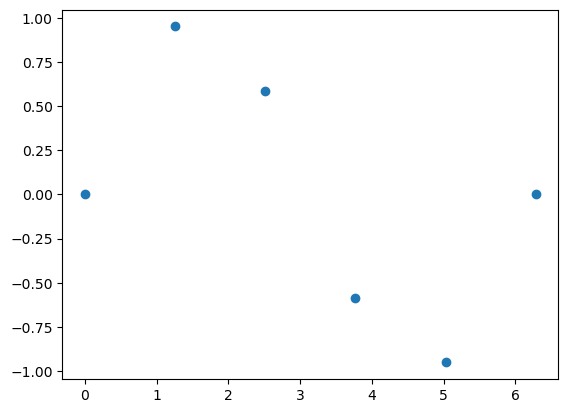

In [147]:
plt.plot(x, y, 'o')
plt.show()

In [148]:
x

[0, 2*pi/5, 4*pi/5, 6*pi/5, 8*pi/5, 2*pi]

In [149]:
y

array([0, sqrt(sqrt(5)/8 + 5/8), sqrt(5/8 - sqrt(5)/8),
       -sqrt(5/8 - sqrt(5)/8), -sqrt(sqrt(5)/8 + 5/8), 0], dtype=object)

In [150]:
x = np.array(x).astype(float)
x

array([0.        , 1.25663706, 2.51327412, 3.76991118, 5.02654825,
       6.28318531])

In [151]:
y = np.array(y).astype(float)
y

array([ 0.        ,  0.95105652,  0.58778525, -0.58778525, -0.95105652,
        0.        ])

In [152]:
from scipy.interpolate import interp1d

f1 = interp1d(x, y, kind = 'linear')

f3 = interp1d(x, y, kind = 'cubic')

In [153]:
a,b

(0, 2*pi)

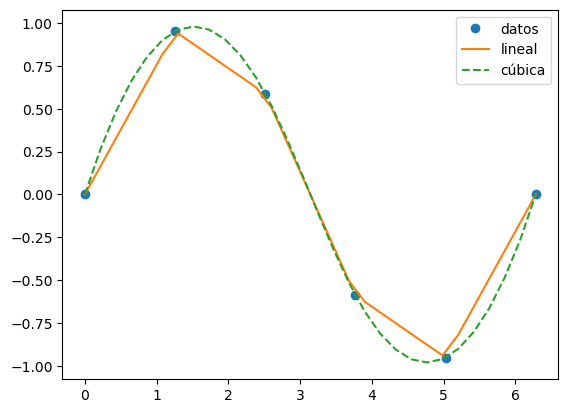

In [154]:
xnew = np.linspace(float(a), float(b), 30)

plt.plot(x, y, 'o', xnew, f1(xnew), '-', xnew, f3(xnew), '--')

plt.legend(['datos', 'lineal', 'cúbica'], loc = 'best')

plt.show()

# Otros ejemplos

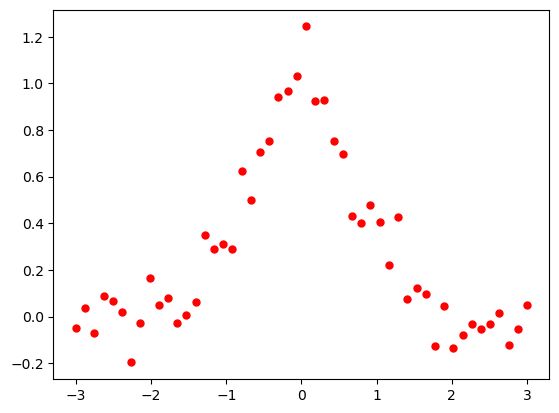

In [155]:
x = np.linspace(-3, 3, 50)
y = np.exp(-x**2) + 0.1 * np.random.randn(50)
plt.plot(x, y, 'ro', ms = 5)
plt.show()

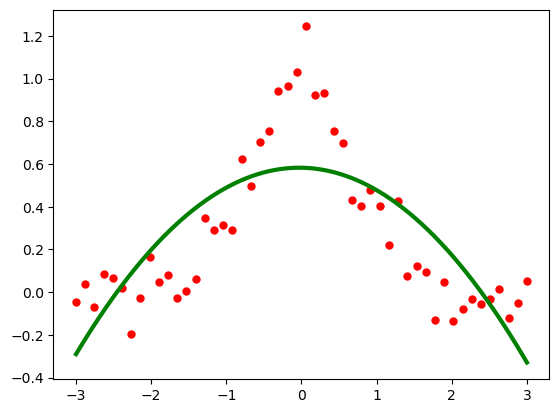

In [156]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(x, y)
xs = np.linspace(-3, 3, 1000)
plt.plot(x, y, 'ro', ms = 5)
plt.plot(xs, spl(xs), 'g', lw = 3)
plt.show()

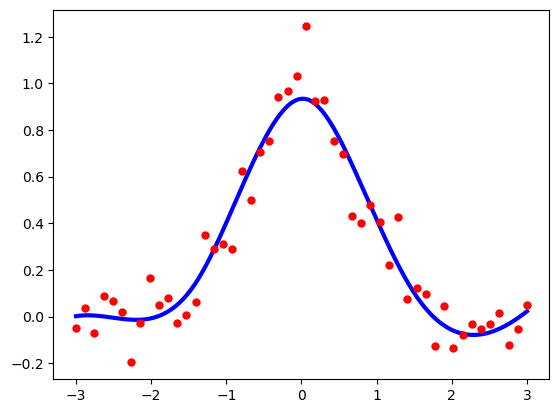

In [157]:
spl.set_smoothing_factor(0.5)
plt.plot(xs, spl(xs), 'b', lw = 3)
plt.plot(x, y, 'ro', ms = 5)
plt.show()

Veamos ahora otros ejemplos variados de interpolación spline usando el procedimiento `interp1d` dentro del submódulo `interpolate` de `SciPy`. 

In [158]:
nx = 8
x  = np.array([i for i in range(nx)])
y  = np.random.random(nx)*10

In [159]:
y

array([0.05549334, 8.72084764, 2.75647894, 9.93192792, 1.34294912,
       0.63713745, 7.00184826, 3.2101191 ])

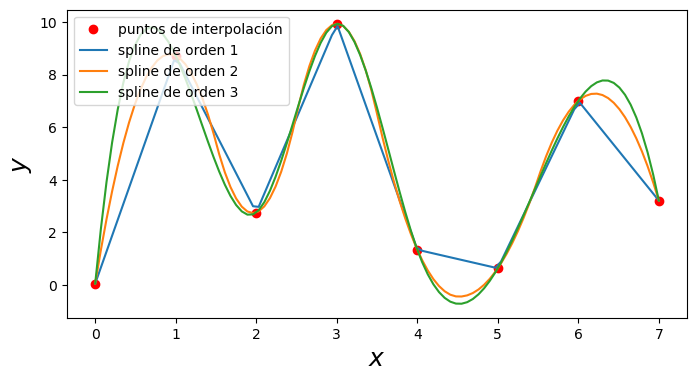

In [160]:
nxx = 100
xx = np.linspace(x[0],x[-1],nxx+1)
# yy = fRunge_vec(xx)
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(x,y,'ro',label='puntos de interpolación')

for n in range(1,4):
    f = interpolate.interp1d(x,y,kind=n)
    ax.plot(xx,f(xx),label = 'spline de orden %d ' % n)

ax.legend(loc=2)
ax.set_xlabel('$x$',fontsize=18)
ax.set_ylabel('$y$',fontsize=18);

# Ejemplo de Runge

In [161]:
def fRunge(x):   # primero definimos la función con la que vamos
    """función 1/(x**2+1) """
    return 1/(x**2+1)   # a efectuar los cálculos en este caso y la
fRunge_vec = np.vectorize(fRunge) # vectorizamos como habitualmente

In [162]:
a,b = -5,5
nx = 10
x  = np.linspace(a,b,nx+1)
y  = fRunge(x)
fi = interpolate.interp1d(x,y, kind=3)

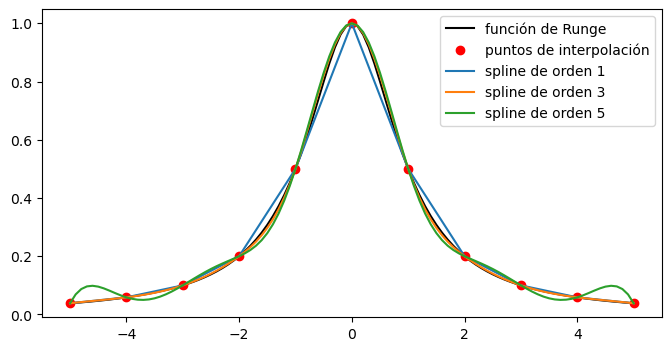

In [163]:
nxx = 100
xx = np.linspace(a,b,nxx+1)
yy = fRunge_vec(xx)
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(xx,yy,'k',label='función de Runge')
ax.plot(x,y,'ro',label='puntos de interpolación')
# ax.plot(xx,fi(xx),'r--',lw=2,label='spline cúbico')

for n in range(1,6,2):
    f = interpolate.interp1d(x,y,kind=n)
    ax.plot(xx,f(xx),label = 'spline de orden %d ' % n)

ax.legend();

## Ejercicios

1.- Halle el spline cúbico sujeto que interpola la función $f(x)=e^x\text{sen}(x)$ en los puntos $x_i = \frac{\pi }{6}i ,\; i=0,\ldots,6$.

2.- Halle el spline cúbico natural que interpola la función $f(x)=\frac{\frac{6}{5}}{x^2+1+\frac{3}{5}}+\frac{1}{5}$ en los nodos resultantes al dividir el intervalo $\left[-\frac{S}{8},\frac{S}{8}\right]$ en siete partes iguales (siendo $S$ la suma de todos los dígitos de su DNI o pasaporte).


3.- Represente los errores de interpolación correspondientes a los tres problemas anteriores.

4.- Implemente ahora alguno de los algoritmos correspondientes a la resolución del spline cúbico de clase $\mathcal{C}^2$ para los casos natural, periódico y sujeto, a partir de la obtención de los valores $M_i\equiv s''(x_i)$, con $i=0,1,\ldots, n$ en vez del cálculo de los $d_i$, con $i=0,1,\ldots, n$.

5.- Reprograme algunos de estos algoritmos de obtención de splines de interpolación usando el lenguaje R, y explore otras opciones mediante librerías propias de dicho lenguaje.